## Resources
tutorial: https://www.youtube.com/watch?v=kCc8FmEb1nY

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tokenizer import SimpleTokenizer
torch.manual_seed(1337)
from dataset import SpeechesClassificationDataset
from tokenizer import SimpleTokenizer

from utilities import Utilities

import nltk
# nltk.download('punkt', download_dir="../data/nltk_punkt")
# nltk.data.path.append("../data/nltk_punkt")

## Tutorial Scratch Space

#### Self-Attention

In [2]:
torch.manual_seed(1337)
# batch size, embedding
#every token here has a two dimensional embedding
#8 tokens per batch (8x2 matrices)
# 4 batches 
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

## HW2 Scratch Space

In [3]:

seed = 42
""" Hyperparameters to use for training to roughly match 
the numbers mentioned in the assignment description """
batch_size = 16  # Number of independent sequences  we will process in parallel
block_size = 32  # Maximum context length for predictions
learning_rate = 1e-3  # Learning rate for the optimizer
n_embd = 64  # Embedding dimension
n_head = 2  # Number of attention heads
n_layer = 4  # Number of transformer layers


eval_interval = 100  # How often to evaluate train and test perplexity during training
max_iters = 500 # For language modeling, we can process all the batches for the entire dataset, but that takes a while, so we'll limit it to 500 iterations. For batch size of 16 and block size of  32, this is roughly, this is  500 * 16 * 32 = 256000 tokens, SOTA LMs are trained on trillions of tokens, so this is a very small dataset.
eval_iters = 200  # Number of iterations to evaluate perplexity on the test set


## classifier training hyperparameters. It is a simple 1 hidden layer feedforward network, with input 
## size of 64, hidden size of 50 and output size of 3.

n_input = 64  # Input size for the classifier, should match the embedding size of the transformer
n_hidden = 100  # Hidden size for the classifier
n_output = 3  # Output size for the classifier, we have 3 classes
epochs_CLS = 15 # epochs for classifier training

In [4]:
with open("../data/speechesdataset/train_LM.txt", "r") as f:
    text = f.read()


# scd = SpeechesClassificationDataset(tokenizer=tok, file_path="data/train_CLS.tsv")

In [5]:
tok = SimpleTokenizer(text=text)

### Positional Encoding

In [6]:
#LOAD DATA
import os
from main import load_texts, DataLoader, collate_batch, LanguageModelingDataset
data_dir = os.path.join("..", "data", "speechesdataset")
print("Loading data and creating tokenizer ...")
texts = load_texts('../data/speechesdataset')
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

train_CLS_dataset = SpeechesClassificationDataset(tokenizer, os.path.join(data_dir, "train_CLS.tsv"))
train_CLS_loader = DataLoader(train_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)

vocab_size = tokenizer.vocab_size

device: cuda
Loading data and creating tokenizer ...
Vocabulary size is 5755


In [7]:
position = torch.arange(block_size).unsqueeze(1)
div_term = torch.exp(torch.arange(0, n_embd, 2) * (-np.log(10000.0) / n_embd))
embedding = nn.Embedding(vocab_size, n_embd)
pe = torch.zeros(block_size, n_embd)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

In [8]:
from transformer import CustomTransformerEncoder
cte_trained = CustomTransformerEncoder(device, vocab_size, block_size, n_embd, n_head, n_layer, n_hidden, n_output).to(device)

In [9]:
# plot_dir = os.path.join("..", "data","plots", "part1")
# u = Utilities(tokenizer, cte_trained, plot_dir, device)
# u.sanity_check("The quick brown fox jumped over the lazy dog.", block_size=block_size)
# u.sanity_check("Doing the same thing and expecting different results is insanity.", block_size=block_size)

In [10]:
sentence = "The quick brown fox jumped over the lazy dog."
encoding = tokenizer.encode(sentence)

In [11]:
padded_sentence = encoding[:block_size] + [0] * (block_size - len(encoding))

In [12]:
input_tensor = torch.tensor(padded_sentence, dtype=torch.long).unsqueeze(0).to(device)

In [13]:
cte2 = CustomTransformerEncoder(device, vocab_size, block_size, n_embd, n_head, n_layer, n_hidden, n_output).to(device)

cte2.load_state_dict(torch.load("../data/models/transformer_encoder.pt"))

<All keys matched successfully>

In [15]:
from main import compute_classifier_accuracy
print("Loading data and creating tokenizer ...")
texts = load_texts("../data/speechesdataset")
tokenizer = SimpleTokenizer(' '.join(texts)) # create a tokenizer from the data
print("Vocabulary size is", tokenizer.vocab_size)

test_CLS_dataset = SpeechesClassificationDataset(tokenizer, os.path.join("../data/speechesdataset", "test_CLS.tsv"))
test_CLS_loader = DataLoader(test_CLS_dataset, batch_size=batch_size,collate_fn=collate_batch,shuffle=True)

compute_classifier_accuracy(cte2, test_CLS_loader, data_dir)

Loading data and creating tokenizer ...
Vocabulary size is 5755


32.93333333333333

In [16]:
cte2._parameters

OrderedDict()

### Plotting

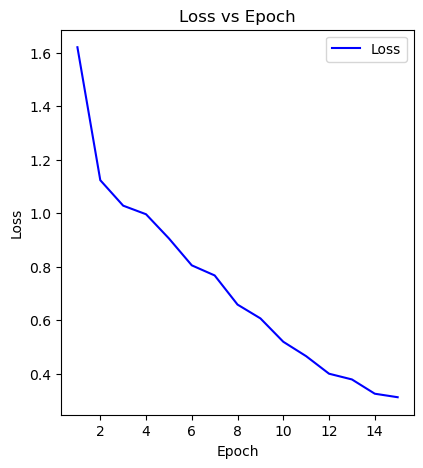

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['loss'], label='Loss', color='blue')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()